### Import data

In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo


import sys
import os
sys.path.append(os.path.abspath(".."))  # Subir un nivel para encontrar src si está en Isolated_Observations
sys.path.append(os.path.abspath("./src"))  # Alternativamente, busca src en la misma carpeta

from src.data_processing import extract_features
from src.model import  self_calculate_bartlett_sphericity


# Load dataset file with labels and features (FCC)
data_path = "../data/"

#dataset ='Automatic_Labeling_Kyoogu/'
dataset ='Dataset_1/'
#dataset ='Dataset_2/'

file = 'Labeled_Data_With_FCCs.xlsx'
df = pd.read_excel(data_path+dataset+file)

columns_to_remove = ['Month', 'Day', 'Hour', 'Length', 'Minute', 'Fmin', 'Fmax', 'View', 'Channel']  

# Remove columns from data frame
df = df.drop(columns_to_remove, axis=1, errors='ignore')
FS = 48000
df.head()



,File,Specie ID,Start,End,FminVoc,FmaxVoc,Peak Freq,Fdom,FCC1,FCC2,...,FCC14,FCC15,FCC16,FCC17,FCC18,FCC19,FCC20,FCC21,FCC22,FCC23
0,SMA03126_20210611_200000.wav,NaN,0.170667,0.789333,2460.9375,3843.7500,3750.00,2601.425305,4.688907,0.839559,...,3.594673,-0.976421,1.120867,0.135650,0.918371,-0.662180,0.958147,-0.601714,-0.230731,1.257794
1,SMA03126_20210611_200000.wav,NaN,0.234667,0.437333,4804.6875,5273.4375,4968.75,4945.175305,-0.578933,-3.233581,...,-1.333951,-2.065569,-1.241812,-0.897783,0.633210,-0.090081,0.141029,0.967930,-0.434016,0.870496
2,SMA03126_20210611_200000.wav,NaN,0.512000,0.672000,6679.6875,7031.2500,6843.75,6867.004573,1.225808,-2.346992,...,-1.600987,0.972749,-0.732687,0.573915,0.248668,-0.514893,-0.667545,0.982099,1.181029,-0.268279
3,SMA03126_20210611_200000.wav,NaN,0.586667,0.714667,4218.7500,4687.5000,4312.50,4546.554878,-2.077138,-0.561821,...,0.084983,-3.908799,0.085132,0.073761,0.215601,-0.916663,-2.142960,1.022725,-0.437987,-1.168378
4,SMA03126_20210611_200000.wav,NaN,0.960000,1.322667,5156.2500,5882.8125,5156.25,5905.518293,-1.458708,0.270924,...,-0.369857,-0.407742,-0.037023,0.302488,-0.213594,0.411494,-1.375533,0.479023,0.172568,0.022479


## Manual extraction of Spectral Features and concatenation with previous features 

In [144]:
# Calculate features for each segment
# Write the path of the DB
audio_path = "../audios/"
if dataset == 'Dataset_2/':
    prefix = audio_path + dataset    
else:
    prefix = audio_path + 'Dataset_1/'   
#prefix = 'C:/Users/jonat/Desktop/PuertoWilches/Audios/All/'


spectral_features = []
for _, fila in df.iterrows():
    file_path = prefix + fila['File']
    #print(f"Processing file: {file_path}")
    features = extract_features(
        path=file_path,
        start=fila['Start'],
        end=fila['End'],
        freq_range=(fila['FminVoc'], fila['FmaxVoc'])
    )
    spectral_features.append(features)

# Convert the list of dictionaries into a DataFrame
df_spectral_features = pd.DataFrame(spectral_features)

# Crate a copy form the original DataFrame
df_copy = df.copy()

# Concatenate the new DataFrame of Spectral features with the copy of the original one. Index should be reset to avoid problems.
df_copy.reset_index(drop=True, inplace=True)
df_spectral_features.reset_index(drop=True, inplace=True)

df_allFeatures = pd.concat([df_copy, df_spectral_features], axis=1)
# Crear la nueva columna 'Length' como la resta de 'End' menos 'Start'
df_allFeatures['Length'] = df_allFeatures['End'] - df_allFeatures['Start']
df_allFeatures['DeltaFreq'] = df_allFeatures['FmaxVoc'] - df_allFeatures['FminVoc']

df_allFeatures

,File,Specie ID,Start,End,FminVoc,FmaxVoc,Peak Freq,Fdom,FCC1,FCC2,...,FCC19,FCC20,FCC21,FCC22,FCC23,spectral_centroid,bandwidth,spectral_flatness,Length,DeltaFreq
0,SMA03126_20210611_200000.wav,NaN,0.170667,0.789333,2460.9375,3843.7500,3750.00,2601.425305,4.688907,0.839559,...,-0.662180,0.958147,-0.601714,-0.230731,1.257794,3600.235116,251.413791,0.312508,0.618667,1382.8125
1,SMA03126_20210611_200000.wav,NaN,0.234667,0.437333,4804.6875,5273.4375,4968.75,4945.175305,-0.578933,-3.233581,...,-0.090081,0.141029,0.967930,-0.434016,0.870496,5049.192484,110.454895,0.429639,0.202667,468.7500
2,SMA03126_20210611_200000.wav,NaN,0.512000,0.672000,6679.6875,7031.2500,6843.75,6867.004573,1.225808,-2.346992,...,-0.514893,-0.667545,0.982099,1.181029,-0.268279,6882.506239,69.451172,0.326579,0.160000,351.5625
3,SMA03126_20210611_200000.wav,NaN,0.586667,0.714667,4218.7500,4687.5000,4312.50,4546.554878,-2.077138,-0.561821,...,-0.916663,-2.142960,1.022725,-0.437987,-1.168378,4405.462955,113.503396,0.550101,0.128000,468.7500
4,SMA03126_20210611_200000.wav,NaN,0.960000,1.322667,5156.2500,5882.8125,5156.25,5905.518293,-1.458708,0.270924,...,0.411494,-1.375533,0.479023,0.172568,0.022479,5298.355153,183.406414,0.932407,0.362667,726.5625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11467,SMA03286_20210605_073000.wav,NaN,52.650667,53.013333,1078.1250,1968.7500,1593.75,1452.759146,-6.329885,-3.175806,...,-0.510744,-2.011136,-1.104959,-0.803322,-0.517911,1509.127973,220.348030,0.770060,0.362667,890.6250
11468,SMA03286_20210605_073000.wav,NaN,53.120000,54.901333,9703.1250,15070.3125,12281.25,13098.246951,-2.924354,-2.784530,...,0.076683,-2.716641,0.076069,0.427814,-0.293979,11763.882832,932.333148,2.050937,1.781333,5367.1875
11469,SMA03286_20210605_073000.wav,Troglodytes_aedon,53.504000,54.378667,3843.7500,4804.6875,4406.25,4827.164634,-2.443030,-2.978437,...,0.025577,-7.264386,-1.538251,-0.461731,-0.417324,4203.047957,244.847510,0.436296,0.874667,960.9375
11470,SMA03286_20210605_073000.wav,NaN,53.930667,54.869333,1148.4375,3093.7500,2718.75,1523.071646,4.789850,0.138461,...,0.404388,-3.922695,-2.416488,-0.319687,0.441293,2645.858987,349.761182,0.422166,0.938667,1945.3125


### Remove noise labels

In [145]:
#if 'sonotype' in df_allFeatures.columns:
df_filtered = df_allFeatures[df_allFeatures['Specie ID'] != 'noise']
#print(df_filtered['Specie ID'].value_counts())
#else:
df_filtered = df_filtered.dropna(subset=['Specie ID'])
print(df_filtered['Specie ID'].value_counts())  

Specie ID
Leptodactylus_fuscus           664
Boana_platanera                264
Nyctidromus_albicollis         152
Dendropsophus_microcephalus    144
Leptodactylus_fragilis          61
Troglodytes_aedon               36
Patagioenas_cayennensis         35
Crotophaga_ani                  33
Crypturellus_soui               32
Amazona_amazonica               11
Dendroplex_picus                10
Alouatta_sp                      9
Pitangus_sulphuratus             7
Ortalis_ruficauda                7
Name: count, dtype: int64


### Divide features and labels, Scale Features

In [146]:
columns_to_remove = ['File','Specie ID','Specie', 'Taxon', 'sonotype', 'Peak Freq']  
df_only_features = df_filtered.drop(columns_to_remove, axis=1, errors='ignore') #Dataframe without labels, only features

# Standardize the features
scaler = StandardScaler()
only_features_scaled = scaler.fit_transform(df_only_features)


### Check Multinormality & Correlation Matrix with spearman

HZResults(hz=5860, pval=0.0, normal=False)


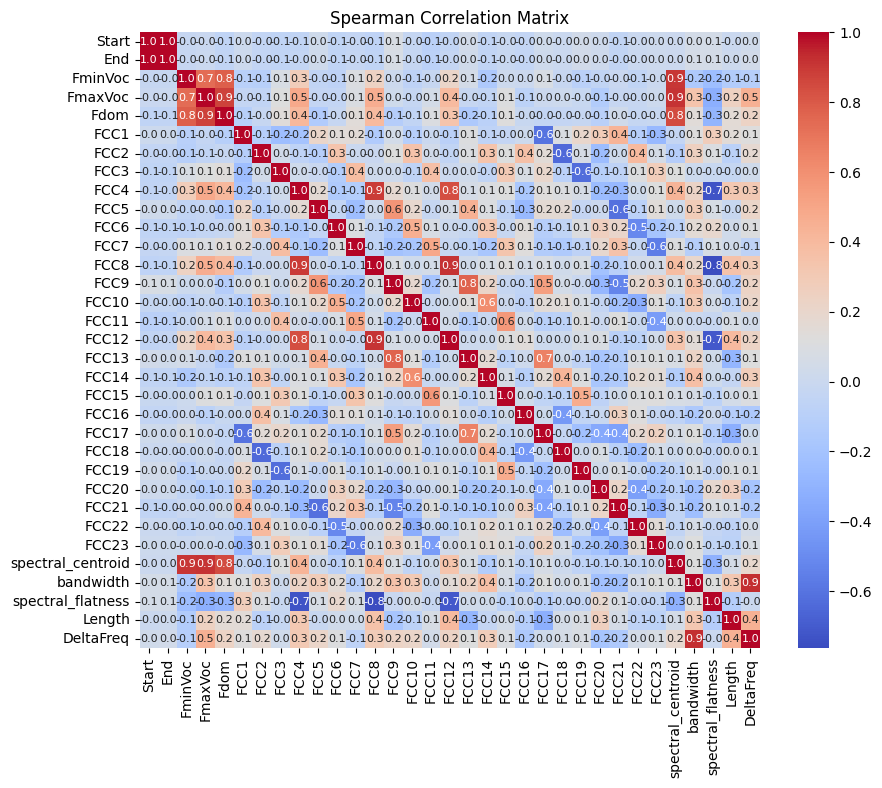

In [147]:
#Normality Test
normality_test = pg.multivariate_normality(only_features_scaled, alpha=0.05)
print(normality_test)

# Convert back to a DataFrame and assign column names
df_only_features_scaled = pd.DataFrame(only_features_scaled, columns=df_only_features.columns)
correlation_matrix = df_only_features_scaled.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

plt.title('Spearman Correlation Matrix')
plt.show()

## Remove variables with high correlation


In [148]:
# Define the threshold for high correlation
threshold = 0.85

# Create a mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Find the variables with high correlation
high_corr_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_vars.add(colname)

#high_corr_vars.add('FCC13')
print("Variables with high correlation:", high_corr_vars)

df_only_features_scaled = df_only_features_scaled.drop(columns=high_corr_vars, errors='ignore')

#print(df_only_features_scaled.head())


Variables with high correlation: {'Fdom', 'FCC8', 'DeltaFreq', 'End', 'spectral_centroid', 'FCC12'}


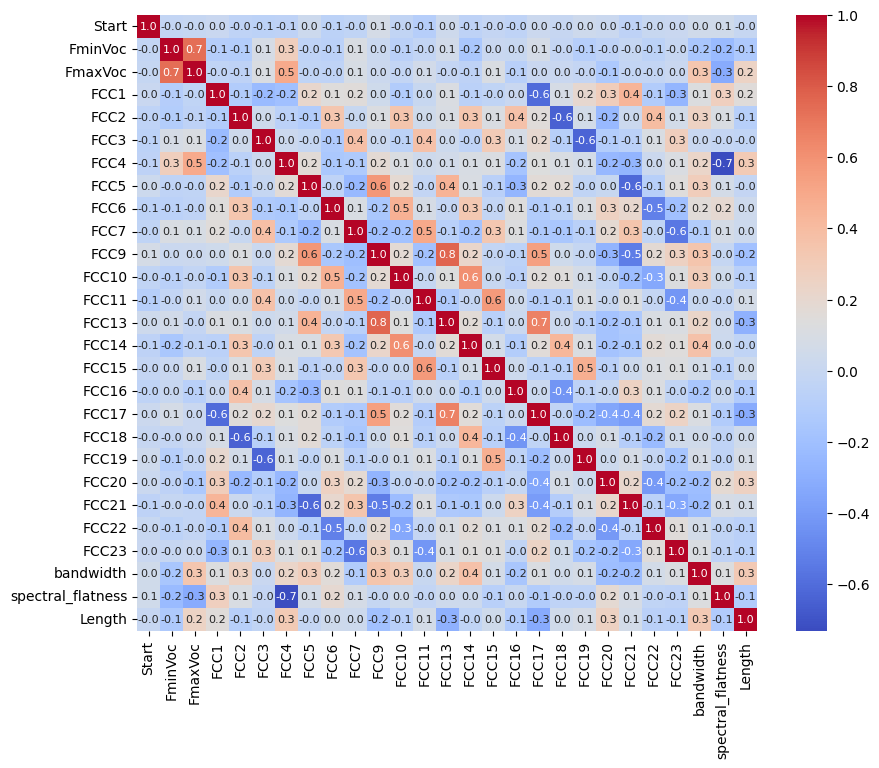

In [149]:
# Display the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))  # Set the size of the figure

# Calculate the correlation matrix using Spearman's method
correlation_matrix_reduced = df_only_features_scaled.corr(method='spearman')

# Generate the heatmap
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

# Show the plot
plt.show()

### Bartlett Test

In [150]:
chi_square_value, p_value = self_calculate_bartlett_sphericity(df_only_features_scaled)
print(f"Results of the Bartlett Test are: Chi-square: {chi_square_value}, p-value: {p_value}")

Results of the Bartlett Test are: Chi-square: 32484.26767838503, p-value: 0.0


### KMO Test

KMO: 0.5145202802047945
Global KMO is not adequate: 0.5145202802047945. Variables with value less than 0.4 are removed.
...
...
Detecting variables with low KMO...


c:\Users\jonat\OneDrive - Universidad de Antioquia\Repositorios\Isolated_Observations\venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


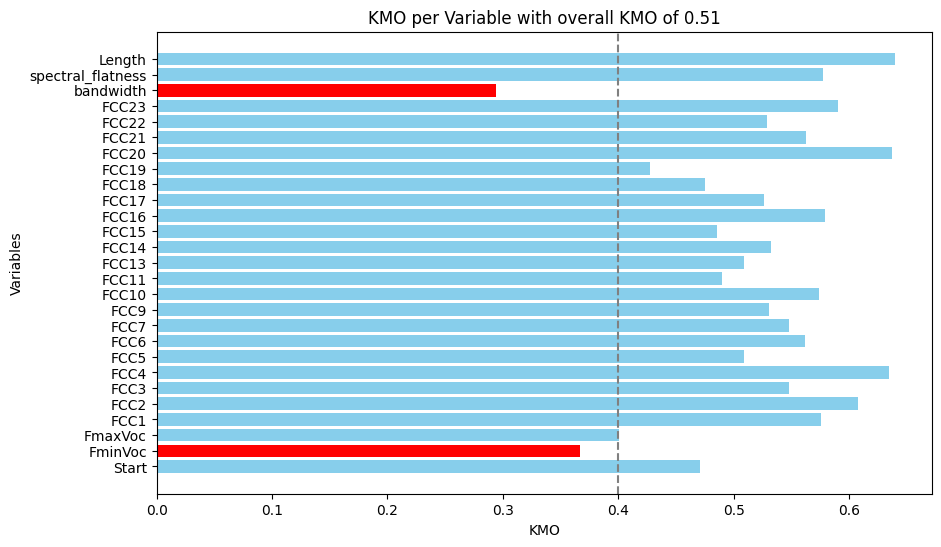

The variables to remove are: 
     Variable
0    FminVoc
1  bandwidth
Calculating the new KMO...
The new KMO value after removing variables is: 0.5311542392337


c:\Users\jonat\OneDrive - Universidad de Antioquia\Repositorios\Isolated_Observations\venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


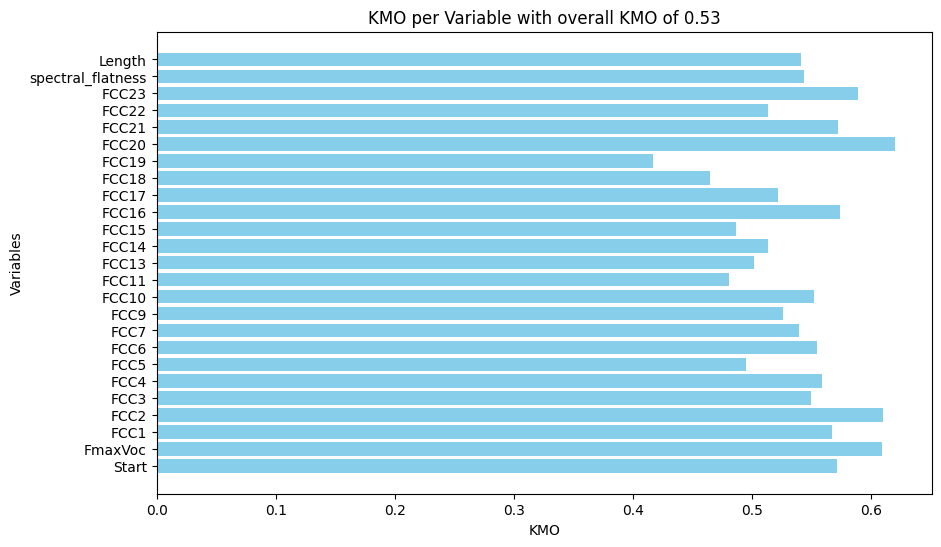

In [151]:
# KMO Test 
kmo_all, kmo_model = calculate_kmo(df_only_features_scaled)
print(f"KMO: {kmo_model}")

# Create a DataFrame with the KMO results for each variable
kmo_df = pd.DataFrame({'Variable': df_only_features_scaled.columns, 'KMO': kmo_all})
variables_to_remove = pd.DataFrame()

while kmo_model < 0.7:
    limit = 0.4
    print(f"Global KMO is not adequate: {kmo_model}. Variables with value less than {limit} are removed.")
    print("...")
    print("...")

    print("Detecting variables with low KMO...")

    # Filter the variables to keep
    variables_to_keep = kmo_df[kmo_df['KMO'] >= limit]['Variable']
    variables_to_remove = pd.concat([variables_to_remove, kmo_df[kmo_df['KMO'] < limit][['Variable']]], ignore_index=True)

    # Create a DataFrame after removing variables with low KMO
    df_filtered_afterKMO = df_only_features_scaled[variables_to_keep]

    # Determine colors for the bars
    colors = ['red' if kmo < limit else 'skyblue' for kmo in kmo_df['KMO']]

    # Visualize the KMO values
    plt.figure(figsize=(10, 6))
    plt.barh(kmo_df['Variable'], kmo_df['KMO'], color=colors)
    plt.xlabel('KMO')
    plt.ylabel('Variables')
    plt.title(f"KMO per Variable with overall KMO of {round(kmo_model, 2)}")
    plt.axvline(x=limit, color='gray', linestyle='--')
    plt.show()
    
    print(f'The variables to remove are: \n {variables_to_remove}')
        
    # Calculate the new KMO
    print("Calculating the new KMO...")
    kmo_all, kmo_model = calculate_kmo(df_filtered_afterKMO)
    kmo_df = pd.DataFrame({'Variable': df_filtered_afterKMO.columns, 'KMO': kmo_all})
    print(f"The new KMO value after removing variables is: {kmo_model}")
    
    if kmo_df[kmo_df['KMO'] < limit]['Variable'].empty:
        break 

# Final visualization of KMO values
plt.figure(figsize=(10, 6))
plt.barh(kmo_df['Variable'], kmo_df['KMO'], color='skyblue')
plt.xlabel('KMO')
plt.ylabel('Variables')
plt.title(f"KMO per Variable with overall KMO of {round(kmo_model, 2)}")
plt.show()


## Estimation of number of factors (Scree plot)

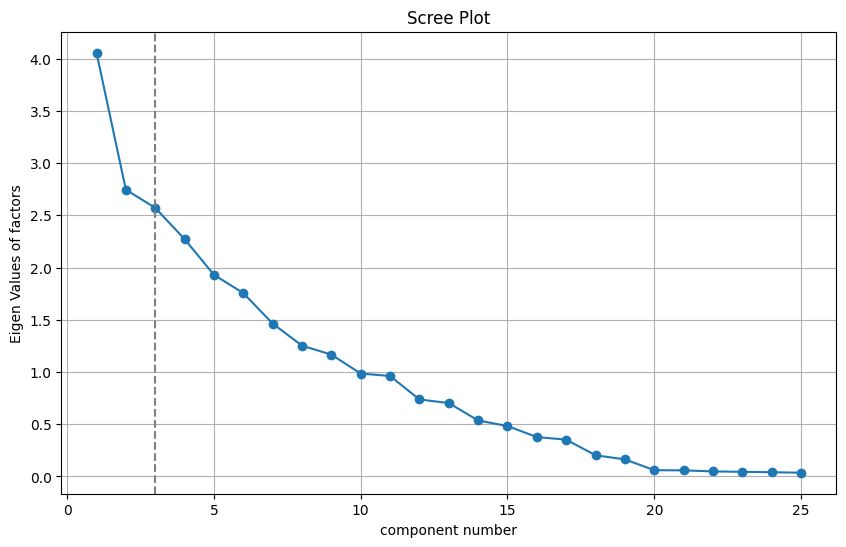

In [152]:
correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa = FactorAnalyzer(n_factors=correlation_matrix_afterKMO.shape[1], rotation=None, is_corr_matrix= True)
fa.fit(correlation_matrix_afterKMO)

# Obtain the eigenvalues
ev, v = fa.get_eigenvalues()

# scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, correlation_matrix_afterKMO.shape[1] + 1), ev, marker='o')
plt.xlabel('component number')
plt.ylabel('Eigen Values of factors')
plt.title('Scree Plot')
plt.axvline(x=3, color='gray', linestyle='--')
plt.grid()
plt.show()

## First Factor Analysis with Varimax Rotation

In [153]:
# Factor Analysis with varimax rotation 
fa1 = FactorAnalyzer(n_factors=3, rotation='varimax', method="minres", is_corr_matrix=True)

# Fit the FactorAnalyzer model on the correlation matrix after KMO filtering
# correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa1.fit(correlation_matrix_afterKMO)

# Obtain loadings
loadings = fa1.loadings_

# Create a DataFrame with the factor loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_afterKMO.columns)

print("Factor loadings:")
print(loadings_df)


Factor loadings:
                    Factor1   Factor2   Factor3
Start              0.069763 -0.026103  0.003007
FmaxVoc           -0.101422  0.080268 -0.403005
FCC1              -0.046464 -0.472244  0.243929
FCC2              -0.059876  0.517722  0.505339
FCC3              -0.208339  0.398428 -0.126396
FCC4               0.111755  0.168532 -0.663531
FCC5               0.602886 -0.024548 -0.092717
FCC6               0.021034 -0.229624  0.448054
FCC7              -0.536048  0.012623  0.103688
FCC9               0.687724  0.372329 -0.000863
FCC10              0.393638  0.006190  0.212636
FCC11             -0.396537  0.077915 -0.023555
FCC13              0.527091  0.325115  0.147503
FCC14              0.375715  0.081300  0.147240
FCC15             -0.264615  0.182479 -0.081943
FCC16             -0.289120  0.270212  0.340975
FCC17              0.434009  0.638145 -0.041344
FCC18              0.363226 -0.422155 -0.305107
FCC19             -0.017843 -0.201096  0.052297
FCC20             -0.13

### Create Latent Variables

In [154]:
# Assign each variable to the factor with the highest loading
assignment = {}
for variable in loadings_df.index:
    max_loading_factor = loadings_df.loc[variable].abs().idxmax()
    max_loading_value = loadings_df.loc[variable, max_loading_factor]
    if round(abs(max_loading_value), 1) >= 0.35:
        assignment[variable] = (max_loading_factor, round(max_loading_value, 1))

# Create the latent variables (factors)
latent_variables = {f'Factor{i+1}': np.zeros(len(df_filtered_afterKMO)) for i in range(loadings.shape[1])}

for variable, (factor, weight) in assignment.items():
    latent_variables[factor] += weight * df_only_features[variable]

# Convert to DataFrame
df_latent = pd.DataFrame(latent_variables)

print("Latent Variables (factors):")
print(df_latent.head())


Latent Variables (factors):
      Factor1   Factor2      Factor3
18  -1.199992  3.504971  -802.455241
21   7.139431  6.651630  -983.474546
24   4.878908  8.702904 -1060.409103
26 -11.914390  1.998143 -1242.348098
30   6.679592  1.986054 -1091.249990


### Obtention of variables with good communalities for analysis

In [155]:
# Obtain the communalities
communalities = fa1.get_communalities()

# Create a DataFrame with the communalities
communalities_df = pd.DataFrame(communalities, index=df_filtered_afterKMO.columns, columns=['Communality'])

# Identify communalities less than 0.3
low_communalities = communalities_df[communalities_df['Communality'] < 0.3]

# Create a DataFrame without variables with communalities less than 0.3
variables_to_keep = communalities_df[communalities_df['Communality'] >= 0.3].index
df_filtered_high_communalities = df_filtered_afterKMO[variables_to_keep]

#print("Communalities:")
#print(communalities_df)

print("\nCommunalities less than 0.3:")
print(low_communalities)

df_filtered_high_communalities



Communalities less than 0.3:
         Communality
Start       0.005557
FmaxVoc     0.179142
FCC1        0.284675
FCC3        0.218126
FCC6        0.253922
FCC7        0.298258
FCC10       0.200204
FCC11       0.163868
FCC14       0.169451
FCC15       0.110035
FCC16       0.272869
FCC19       0.043493
FCC22       0.267015
FCC23       0.232914
Length      0.171907


,FCC2,FCC4,FCC5,FCC9,FCC13,FCC17,FCC18,FCC20,FCC21,spectral_flatness
0,0.003891,-1.199705,-0.316950,-0.268814,-0.004851,0.273756,0.167875,0.379678,0.175298,0.882719
1,0.329964,-0.801647,0.895741,0.296909,1.113721,1.313960,0.592342,-0.704296,-0.428525,0.748572
2,0.871468,-0.705695,-0.551040,1.549468,0.829943,0.920467,-1.191027,-1.293477,-0.397787,0.378921
3,-1.225916,-1.222769,-1.672709,-1.100311,-0.545552,-0.064774,1.492931,-0.109978,1.235664,0.306256
4,-1.868524,-0.348149,1.495110,0.093533,0.820258,1.413472,1.631309,-0.255978,-1.130406,0.031270
...,...,...,...,...,...,...,...,...,...,...
1460,-0.229245,0.472207,-0.546300,-0.971267,-1.343454,-0.859671,-0.177025,-0.463367,0.021773,-0.291414
1461,0.556977,0.392125,1.420884,0.562517,0.529828,-0.361447,-0.830310,-0.729510,-0.377596,0.424007
1462,-0.856766,0.400163,-0.456505,-0.418507,-0.648188,-0.032931,0.389327,-0.687997,-0.198028,-0.005596
1463,0.487536,0.293990,1.776082,1.842275,1.270689,0.357802,-0.158613,-0.297479,-1.138605,0.064977


### Scree plot

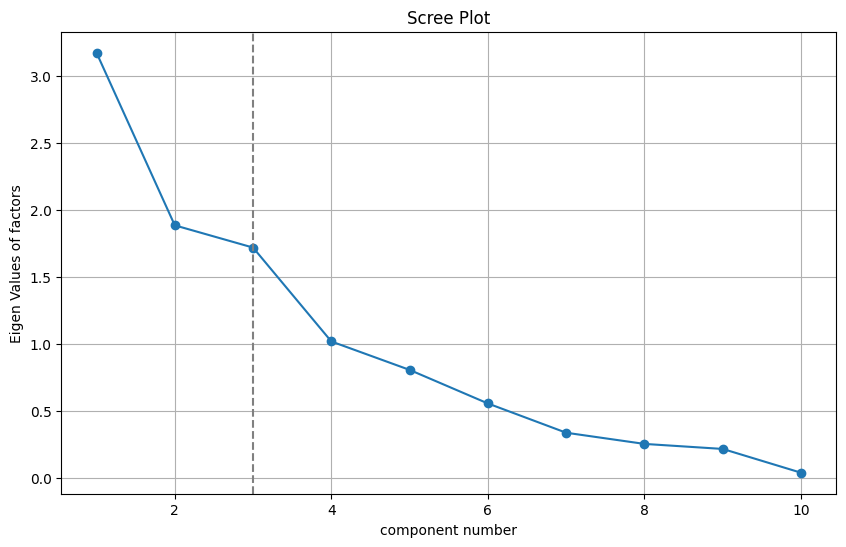

In [156]:
correlation_matrix_aftercommunalities = df_filtered_high_communalities.corr(method='spearman')
fa = FactorAnalyzer(n_factors=df_filtered_high_communalities.shape[1], rotation=None, is_corr_matrix= True)
fa.fit(correlation_matrix_aftercommunalities)

# Obtain the eigenvalues
ev, v = fa.get_eigenvalues()

# scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, correlation_matrix_aftercommunalities.shape[1] + 1), ev, marker='o')
plt.xlabel('component number')
plt.ylabel('Eigen Values of factors')
plt.title('Scree Plot')
plt.axvline(x=3, color='gray', linestyle='--')
plt.grid()
plt.show()

### KMO test after removal of variables with low communalities

In [157]:
kmo_all, kmo_model = calculate_kmo(df_filtered_high_communalities)
print(f"KMO: {kmo_model}")

KMO: 0.5949213921952321


c:\Users\jonat\OneDrive - Universidad de Antioquia\Repositorios\Isolated_Observations\venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


### Second Factor Anlysis with Varimax Rotation

In [158]:
# Factor Analysis with varimax rotation 
fa2 = FactorAnalyzer(n_factors=3, rotation='varimax', method = "minres", is_corr_matrix= True)

#correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa2.fit(correlation_matrix_aftercommunalities)

# Obtain loadings
loadings = fa2.loadings_

# Create a Dataframe with the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_high_communalities.columns)

print("Loadings:")
print(loadings_df)

Loadings:
                    Factor1   Factor2   Factor3
FCC2               0.070646  0.044623  0.874481
FCC4               0.153445 -0.869373 -0.078775
FCC5               0.631618  0.012305 -0.250499
FCC9               0.942126 -0.040131  0.052649
FCC13              0.751776  0.050294  0.104987
FCC17              0.622287 -0.134943  0.204151
FCC18              0.086601 -0.049262 -0.677849
FCC20             -0.265923  0.270332 -0.260774
FCC21             -0.558433  0.182370  0.113178
spectral_flatness  0.038999  0.830888  0.032069


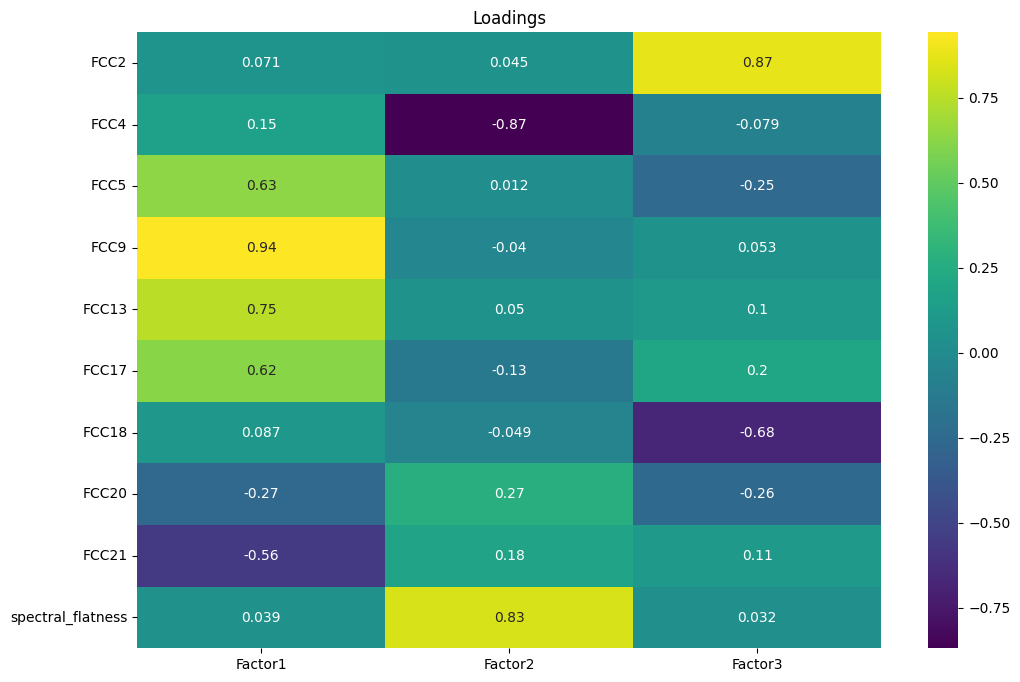

In [159]:
# Ploting the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='viridis')
plt.title('Loadings')
plt.show()

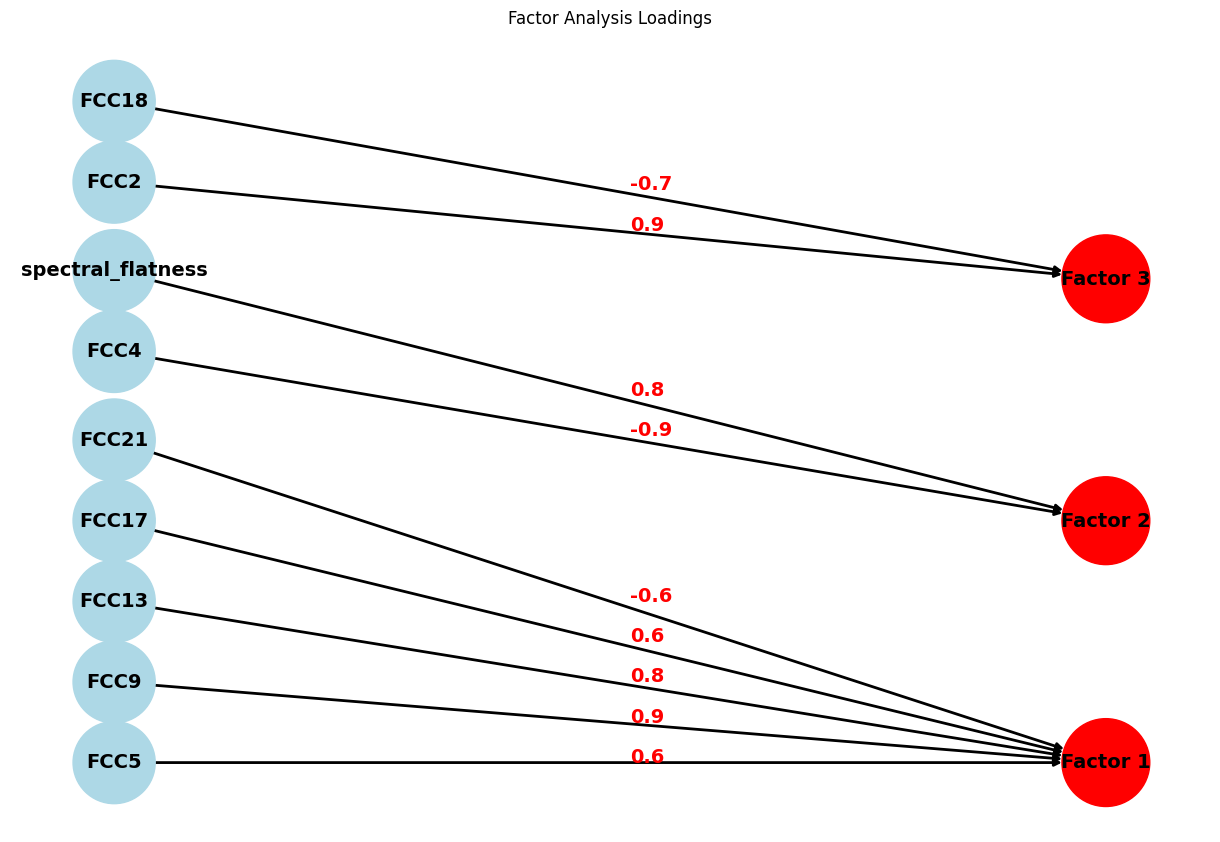

In [160]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_factor_loadings(loadings_df, factor_size=3000, variable_size=2000, font_size=12):
    # Create the graph
    G = nx.DiGraph()

    # Define the spacing between nodes
    space = 1  # Increase the spacing between variables of the same factor
    group_space_multiplier = 0.1  # Further reduce the extra space between different factor groups

    # Create a custom layout
    pos = {}
    y_offset_factors = 0  # Initial y offset for factors
    y_offset_variables = 0  # Initial y offset for variables

    # Assign each variable to the factor with the highest loading
    assignment = {}
    for variable in loadings_df.index:
        max_loading_factor = loadings_df.loc[variable].abs().idxmax()
        max_loading_value = loadings_df.loc[variable, max_loading_factor]
        if abs(max_loading_value) > 0.35:
            assignment[variable] = (max_loading_factor, max_loading_value)

    # Create factor nodes and assign initial positions
    factor_positions = {}
    factor_spacing = len(assignment) * space / len(loadings_df.columns)  # Adjust spacing
    for factor_index, factor in enumerate(loadings_df.columns):
        factor_name = f'Factor {factor_index + 1}'
        G.add_node(factor_name, color='red', size=factor_size)
        factor_positions[factor_name] = y_offset_factors
        pos[factor_name] = (1, y_offset_factors)
        y_offset_factors += factor_spacing

    # Position and add variables to the graph, grouping by factor
    for factor_index, factor in enumerate(loadings_df.columns):
        factor_name = f'Factor {factor_index + 1}'

        # Assign positions to variables assigned to this factor
        for variable, (assigned_factor, weight) in assignment.items():
            if assigned_factor == factor:
                pos[variable] = (0, y_offset_variables)
                G.add_node(variable, color='lightblue', size=variable_size)
                G.add_edge(variable, factor_name, weight=round(weight, 1))
                y_offset_variables += space

        # Add extra space between groups
        y_offset_variables += space * group_space_multiplier

    # Colors and sizes
    node_colors = [nx.get_node_attributes(G, 'color').get(node, 'lightblue') for node in G.nodes()]
    node_sizes = [nx.get_node_attributes(G, 'size').get(node, variable_size) for node in G.nodes()]
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='black', width=2, font_size=font_size, font_color='black', font_weight='bold')

    # Edge labels with one decimal place
    for (u, v), weight in edge_labels.items():
        x_pos = (pos[u][0] + pos[v][0]) / 2 + 0.02  # Horizontal adjustment
        y_pos = (pos[u][1] + pos[v][1]) / 2
        plt.text(x_pos, y_pos, f'{weight:.1f}', color='red', fontsize=font_size, fontweight='bold')

    plt.title('Factor Analysis Loadings')
    plt.show()

# Call the function to plot with a custom font size
plot_factor_loadings(loadings_df, factor_size=4000, variable_size=3500, font_size=14)

### Create latent variables

In [161]:
# # Assign each variable to the factor with the highest loading
# assignment = {}
# for variable in loadings_df.index:
#     max_loading_factor = loadings_df.loc[variable].abs().idxmax()
#     max_loading_value = loadings_df.loc[variable, max_loading_factor]
#     if round(abs(max_loading_value), 1) >= 0.4:
#         assignment[variable] = (max_loading_factor, round(max_loading_value, 1))

# # Create the latent variables (factors)
# latent_variables = {f'Factor{i+1}': np.zeros(len(df_filtered_high_communalities)) for i in range(loadings.shape[1])}

# for variable, (factor, weight) in assignment.items():
#     latent_variables[factor] += weight * df_only_features[variable]

# # Convert to DataFrame
# df_latent = pd.DataFrame(latent_variables)


# print("Latent variables (factors):")
# print(df_latent.head())

### Create new dataset only with the latent variables and two other variables.

In [ ]:
# Extract the 'bandwidth' variable
bandwidth_df = df_only_features[['bandwidth']]
spectral_flatness_df = df_only_features[['spectral_flatness']]
Length_df = df_only_features[['Length']]
DeltaFreq_df = df_only_features[['DeltaFreq']]
spectral_centroid_df = df_only_features[['spectral_centroid']]
FminVoc_df =  df_only_features[['FminVoc']]


if dataset == 'Automatic_Labeling_Kyoogu/':
    df_reduced2 = pd.concat([df_latent, Length_df, DeltaFreq_df], axis=1)
elif dataset == 'Dataset_1/':
    df_reduced2 = pd.concat([df_latent, bandwidth_df, Length_df], axis=1)
    #df_reduced2 = pd.concat([df_latent, bandwidth_df, FminVoc_df], axis=1)
else:
    df_reduced2 = pd.concat([df_latent, spectral_flatness_df, DeltaFreq_df], axis=1)


#df_reduced2 = df_latent.copy()

# Concatenate the latent variables with 'bandwidth'
df_reduced2['Specie_ID'] = df_filtered['Specie ID']


print("Combined DataFrame:")
print(df_reduced2.head())


outputfile = 'reduced_dataframe_FA2.xlsx'
df_reduced2.to_excel(data_path+dataset+outputfile,index=True)


Combined DataFrame:
      Factor1   Factor2      Factor3             Specie_ID
18  -1.199992  3.504971  -802.455241       Boana_platanera
21   7.139431  6.651630  -983.474546  Leptodactylus_fuscus
24   4.878908  8.702904 -1060.409103  Leptodactylus_fuscus
26 -11.914390  1.998143 -1242.348098  Leptodactylus_fuscus
30   6.679592  1.986054 -1091.249990  Leptodactylus_fuscus
